In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [33]:
# Load data
data = pd.read_csv('youtube_multi_channel_data.csv')
data['published_date'] = pd.to_datetime(data['published_date'])
data['day'] = data['published_date'].dt.day_name()

Feature Engineering:

In [34]:
epsilon = 1e-10
data['like_ratio'] = data['likes'] / (data['views'] + epsilon)
data['view_ratio'] = data['views'] / (data['comments'] + epsilon)
data['comment_ratio'] = data['comments'] / (data['views'] + epsilon)

In [35]:
# Impute NaN with median
numerical_cols = ['like_ratio', 'view_ratio', 'comment_ratio']
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())

In [36]:
# Additional temporal features
data['month'] = data['published_date'].dt.month
data['year'] = data['published_date'].dt.year
data['day_of_month'] = data['published_date'].dt.day
data['week_of_year'] = data['published_date'].dt.isocalendar().week
data['quarter'] = data['published_date'].dt.quarter
data['is_weekend'] = data['day'].isin(['Saturday', 'Sunday']).astype(int)

In [5]:
data.columns

Index(['channel_title', 'video_title', 'views', 'likes', 'comments',
       'published_date', 'day', 'like_ratio', 'view_ratio', 'comment_ratio',
       'month', 'year', 'day_of_month', 'week_of_year', 'quarter',
       'is_weekend'],
      dtype='object')

In [37]:
# One-hot encoding
data = pd.get_dummies(data, columns=['day'], prefix='day')
data = pd.get_dummies(data, columns=['channel_title'], prefix='channel_title')

In [38]:
# Target
data['log_views'] = np.log1p(data['views'])

In [39]:
viral_threshold = 100000
data['is_viral'] = (data['views'] >= viral_threshold).astype(int)

In [40]:
# Feature selection (exclude likes, comments)
feature_columns = [col for col in data.columns if col not in ['views', 'log_views', 'is_viral', 'published_date', 'video_title', 'likes', 'comments']]
X = data[feature_columns]
y_reg = data['log_views']

In [41]:
# Train-test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42, stratify=data['year']
)

In [42]:
# Verify no inf/NaN
print("NaN in X_train_reg:", X_train_reg.isna().sum().sum())
print("Inf in X_train_reg:", np.isinf(X_train_reg[numerical_cols]).sum().sum())
print("NaN in y_train_reg:", y_train_reg.isna().sum())
print("Inf in y_train_reg:", np.isinf(y_train_reg).sum())

NaN in X_train_reg: 0
Inf in X_train_reg: 0
NaN in y_train_reg: 0
Inf in y_train_reg: 0


In [50]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
reg_model = XGBRegressor(random_state=42)

grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_reg, y_train_reg)
print("Best parameters:", grid_search.best_params_)
print("Best R²:", grid_search.best_score_)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.7}
Best R²: 0.8007783860815906


In [53]:
# Train final model
reg_model.fit(X_train_reg, y_train_reg)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [54]:
# Evaluate on test set
y_pred_reg = reg_model.predict(X_test_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)
print(f"Test MAE (log scale): {mae:.2f}")
print(f"Test RMSE (log scale): {rmse:.2f}")
print(f"Test R²: {r2:.2f}")

Test MAE (log scale): 0.77
Test RMSE (log scale): 1.05
Test R²: 0.78


In [55]:
# Original views scale
y_pred_views = np.expm1(y_pred_reg)
y_test_views = np.expm1(y_test_reg)
mae_views = mean_absolute_error(y_test_views, y_pred_views)
rmse_views = np.sqrt(mean_squared_error(y_test_views, y_pred_views))
print(f"Test MAE (original views): {mae_views:.2f}")
print(f"Test RMSE (original views): {rmse_views:.2f}")

Test MAE (original views): 353704.42
Test RMSE (original views): 1416881.56


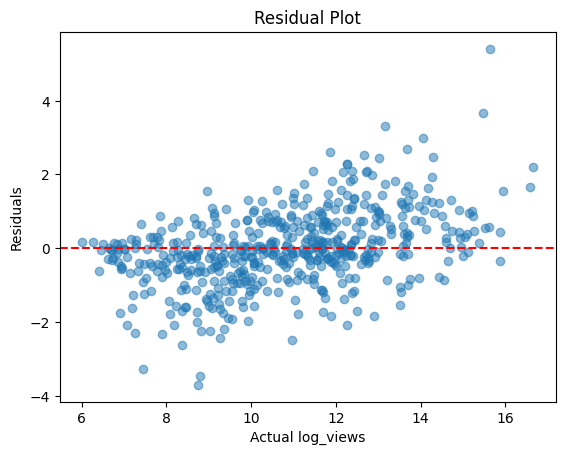

In [47]:
# Residual plot
residuals = y_test_reg - y_pred_reg
plt.scatter(y_test_reg, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual log_views")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


end

In [49]:
data.to_csv('dataset_with_targets.csv', index=False)